In [1]:
import bclr
import ruptures as rpt
import numpy as np
from ruptures.metrics import randindex
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from scipy.stats import multivariate_normal, binom
import matplotlib.pyplot as plt
import pandas as pd
import changeforest
from sklearn.linear_model import LogisticRegression

pf = PolynomialFeatures(include_bias=False)
ss = StandardScaler()

Multiple changepoint demo

In [8]:
np.random.seed(191293)
n, dim = 500, 3  # number of samples, dimension
n_bkps, sigma = 5, 5  # number of change points, noise standard deviation
signal, bkps = rpt.pw_constant(n, dim, n_bkps, noise_std=sigma)
prior_cov=np.diag(np.repeat(2, 3))
bclrM = bclr.MultiBayesCC(signal, cps=10, prior_cov=prior_cov, n_iter=1000, min_size=30)
bclrM.warm_up(reps=10)

bclr_multi.py:173: SegmentationWarning: Number of changepoints reduced due to nan values owing to min_size constraints specified in MultiBayesCC... 



In [9]:
print(bkps[:-1], "\n")
print("Number of changepoints seeded for 'bkps':", len(bclrM.bkps)-2, "\n")
print(bclrM.bkps[1:-1])

[79, 163, 244, 327, 409] 

Number of changepoints seeded for 'bkps': 5 

[64, 163, 244, 327, 409]


In [10]:
bclrM.fit()

In [14]:
bclrM.transform()
thr = 0.5
dfM = bclrM.cps_df(thr=thr)
dfM

,Location,Posterior Probability,Normalized Entropy
0,79.0,0.922,0.056930
1,163.0,0.768,0.171851
2,244.0,0.848,0.115426
3,327.0,0.934,0.064301
4,409.0,0.946,0.048719


In [16]:
est_change = dfM['Location'].to_list()
print(est_change)
print(randindex(est_change + [n], bkps))

[79.0, 163.0, 244.0, 327.0, 409.0]
1.0


### Correctly identifies the changes in each coordinate!!!

In [17]:
[np.mean(bc.post_beta > 0, axis=0) for bc in bclrM.bccs_]

[array([1.   , 0.042, 0.   ]),
 array([0.   , 1.   , 0.054]),
 array([0.066, 1.   , 0.988]),
 array([1.   , 1.   , 0.986]),
 array([0., 1., 1.])]

In [18]:
[bc.post_beta_mean for bc in bclrM.bccs_]

[array([ 3.09460779, -0.56281167, -1.93608942]),
 array([-2.08764881,  1.41463398, -0.37189169]),
 array([-0.32938677,  2.42770998,  0.51130913]),
 array([1.94644711, 1.51451731, 0.57152101]),
 array([-1.554364  ,  2.6777171 ,  2.04277248])]

In [19]:
bkps2 = [0]+bkps
for i in range(len(bkps2)-1):
    print(np.mean(signal[bkps2[i]:bkps2[i+1], :], axis=0))

[  2.14118585   4.9012142  -10.73957328]
[ 11.75726036   3.8355568  -18.81885857]
[  2.68176641  10.07653141 -19.87143008]
[  1.04579881  18.90791009 -17.65649024]
[  9.26447     25.36731505 -15.07296321]
[ 2.85699635 35.7892248  -7.14742936]


In [20]:
kern_cpd = rpt.KernelCPD(kernel='rbf')
cp_kcp = kern_cpd.fit_predict(signal, pen=2)
print(cp_kcp[:-1])
print(randindex(cp_kcp, bkps))

[79, 163, 244, 327, 409]
1.0


In [21]:
cp_cf = changeforest.changeforest(signal).split_points()
print(cp_cf)
print(randindex(cp_cf + [n], bkps))

[79, 163, 244, 327, 409]
1.0


## What if we looked at changes of differing nature?

In [100]:
np.random.seed(881923)
h1 = np.array([[1, 0.2, 0.1], [0.2, 1, 0], [0.1, 0, 1]])
h2 = np.array([[4, 0.2, 0.1], [0.2, 1, 0], [0.1, 0, 1]])
L1 = np.linalg.cholesky(h1)
L2 = np.linalg.cholesky(h2)

a = np.random.randn(100, 3) @ L1
b = np.random.randn(75, 3) @ L2
c = np.random.randn(30, 3) @ L2 + np.broadcast_to([0, 3, -1], (30, 3))

Xnew = pf.fit_transform(ss.fit_transform(np.r_[a,b,c]))

In [101]:
prior_cov9 = np.diag(np.repeat(1, 9))

In [102]:
bclrM_new = bclr.MultiBayesCC(Xnew, cps=5, prior_cov=prior_cov9, n_iter=1000, min_size=25)
bclrM_new.warm_up(reps=10)
bclrM_new.fit()

bclr_multi.py:173: SegmentationWarning: Number of changepoints reduced due to nan values owing to min_size constraints specified in MultiBayesCC... 



In [109]:
bclrM_new.transform()
bclrM_new.cps_df(thr=thr)

,Location,Posterior Probability,Normalized Entropy
1,103.0,0.258,0.453432
2,175.0,0.904,0.077156


### Now we can summarize the output of our algorithm...

In [104]:
[np.mean(bc.post_beta > 0, axis=0) for bc in bclrM_new.bccs_]

[array([0.806, 0.474, 0.276, 0.156, 0.988, 0.926, 0.716, 0.508, 0.45 ]),
 array([0.19 , 0.66 , 0.668, 1.   , 0.212, 0.372, 0.766, 0.582, 0.638]),
 array([0.38 , 1.   , 0.252, 0.31 , 0.304, 0.186, 1.   , 0.184, 0.044])]

In [105]:
# This indciates that the x_1^2 increases the most in the first instance, 
# and x_2 for the second changepoint, thought x_2^2 is close...
[bc.post_beta_mean for bc in bclrM_new.bccs_]

[array([ 0.26787289, -0.01235875, -0.18006796, -0.25337554,  0.89532072,
         0.3780556 ,  0.19192587,  0.01611073, -0.01719657]),
 array([-0.27688422,  0.08909597,  0.10097691,  1.67782168, -0.26337756,
        -0.07902338,  0.20650973,  0.07196628,  0.08419072]),
 array([-0.09290673,  2.53120675, -0.2696673 , -0.19785884, -0.28011051,
        -0.39011597,  2.49997063, -0.66704694, -0.72863886])]

In [108]:
# Usual rbf kernel with dynamic programming to find the changes...
kern_cpd.fit_predict(Xnew, pen=2)

[175, 205]

In [107]:
changeforest.changeforest(Xnew).split_points()

[103, 175]

### Central England temperature series

In [54]:
import re
f = open("mean_temps_central_england.txt", "r")
lines = [re.sub(r"\n", "", re.sub(r"[ ]+", " ", a)).split(" ") for a in f.readlines()]

In [55]:
mtu = pd.DataFrame([l[1:] for l in lines[5:]], columns=lines[4][1:])
Xcet = mtu[['Annual']][:-1].to_numpy(dtype=np.double)

In [56]:
cps = list(np.array([1700, 1738, 1988])-1658)

In [84]:
prior_cov1 = np.diag(np.repeat(10,1))
ncps = 7
bclrM_cet = bclr.MultiBayesCC(Xcet, cps=ncps, prior_cov=prior_cov1, min_size=20,
                              n_iter=1000, lam=0) #try also 9 changepoints to see what we find...
bclrM_cet.warm_up(reps=20)

bclr_multi.py:173: SegmentationWarning: Number of changepoints reduced due to nan values owing to min_size constraints specified in MultiBayesCC... 



In [85]:
print(bclrM_cet.bkps)
bclrM_cet.prior_cov = np.diag(np.repeat(1,1))
bclrM_cet.lam = 0
bclrM_cet.fit()

[0, 42, 104, 135, 178, 270, 330, 365]


In [97]:
bclrM_cet.transform()
df_dis = bclrM_cet.cps_df(1658, thr=0.7)
print(df_dis.sort_values(by=['Posterior Probability'], ascending=False))

   Location  Posterior Probability  Normalized Entropy
5    1988.0                  0.396            0.358995
0    1701.0                  0.182            0.541514


In [98]:
from ecp import e_divisive

In [92]:
1658 + np.array([330, 43, 267, 81])

array([1988, 1701, 1925, 1739])

In [93]:
ecp_vals = e_divisive.e_divisive(Xcet)
np.array(ecp_vals['estimates'][1:-1]) + 1658

array([1701, 1925, 1988])

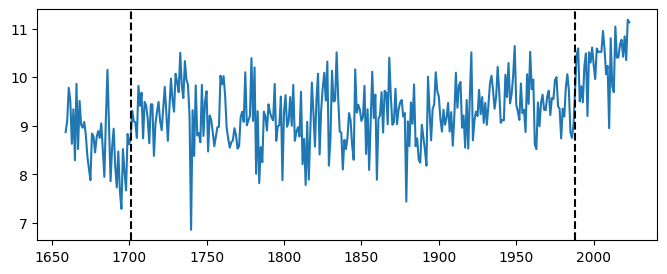

In [99]:
plt.figure(figsize=(8, 3))
Xcet = mtu[['Annual']][:-1].to_numpy(dtype=np.double)
years = mtu[['Year']][:-1].to_numpy(dtype=np.double)
plt.plot(years[:], Xcet[:])
[plt.axvline(df_dis['Location'].iloc[i], color='black', linestyle='--') for i in range(len(df_dis))]

In [95]:
np.array(kern_cpd.fit_predict(Xcet, n_bkps = 3)[:-1])+1658

array([1699, 1910, 1987])

In [96]:
op = changeforest.changeforest(Xcet)
np.array(op.split_points())+1658

array([1982, 1988])